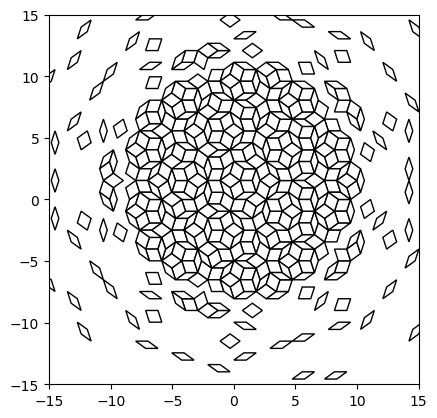

In [2]:
from itertools import combinations
from collections import defaultdict
from math import isclose

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon

rng = np.random.default_rng(seed=1)

grid_count = 5
grid_bounds = [-3, 3]
grid_bounds[1] += 1
cos_list = [np.cos(x * np.pi / grid_count) for x in np.arange(grid_count)]
sin_list = [np.sin(x * np.pi / grid_count) for x in np.arange(grid_count)]

offsets = rng.uniform(size=5)
offsets = offsets / np.sum(offsets)
offsets = np.repeat(1/grid_count, grid_count)
#offsets = np.repeat(.25, grid_count)
offsets = np.empty((grid_count,),float)
offsets[::2] = (1/grid_count)
offsets[1::2] = -(1/grid_count)
#offsets = np.repeat(0, grid_count)
#offsets = np.repeat(1/grid_count, grid_count)

class Line:
    # a*x + b*y = c
    def __init__(self, a, b, c, grid):
        self.a = a
        self.b = b
        self.c = c
        self.grid = grid

    # Build function to get lines that hit boundaries
    # Maybe use build intersection function and use a line for each boundary!!!???
    def determine_intersection(self, other_line):
        denom = (self.a * other_line.b) - (other_line.a * self.b)
        if isclose(denom, 0, rel_tol=1e-5, abs_tol=1e-05):
            return False
        else:
            x = (other_line.b * self.c) - (self.b * other_line.c)
            x = x / denom

            y = (self.a * other_line.c) - (other_line.a * self.c)
            y = y / denom

            return (x, y)
        
def determine_K(c, x, s, y, o):
    return np.ceil(c * x + s * y - o)
        
grids = []
for i, (s, c, o) in enumerate(zip(sin_list, cos_list, offsets)):
    for k in np.arange(*grid_bounds):
        grids.append(Line(c, s, o + k, i))

boundary = [Line(0, 1, 5, 0), Line(0, 1, -5, 0), Line(1, 0, 5, 0), Line(1, 0, -5, 0)]

draw_lines = []

for l in grids:
    points = []
    for b in boundary:
        intersection = l.determine_intersection(b)
        if intersection:
            if np.abs(intersection[0]) <= 5 and np.abs(intersection[1]) <= 5:
                points.append(intersection)
    draw_lines.append(points)

colors = ["blue", "green", "yellow", "orange", "red"]
colors = np.repeat(colors, len(draw_lines) / 5)

intersections = defaultdict(set)
for pair in combinations(grids, 2):
    l1 = pair[0]
    l2 = pair[1]
    intersection = l1.determine_intersection(l2)
    if intersection:
        intersections[intersection].update([l1, l2])


polygons = []
for intersection, lines in intersections.items():
    grid_numbers = []
    for l in lines:
        grid_numbers.append(l.grid)

    this_offsets = offsets.copy()
    for g in grid_numbers:
        this_offsets[g] += .5

    ks = [determine_K(c, intersection[0], s, intersection[1], o) for c, s, o in zip(cos_list, sin_list, this_offsets)]

    points = []
    for r in range(len(grid_numbers) + 1):
        for intersection_grids in combinations(grid_numbers, r):
            this_k = ks.copy()
            for grid in intersection_grids:
                this_k[grid] += 1
            
            point = np.array([0, 0], dtype=float)
            for k, c, s in zip(this_k, cos_list, sin_list):
                point += k * np.array([c, s])
            points.append(point)

    mean_x = np.mean([x[0] for x in points])
    mean_y = np.mean([y[1] for y in points])

    angles = []
    for point in points:
        angles.append(np.arctan2(point[1] - mean_y, point[0] - mean_x))

    polygon = [point for _, point in sorted(zip(angles, points))]
    polygons.append(polygon)

fig,ax = plt.subplots()

for polygon in polygons:
    p = Polygon(polygon, facecolor = 'w', edgecolor="k")
    ax.add_patch(p)
    
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
ax.set_aspect('equal')
plt.show()

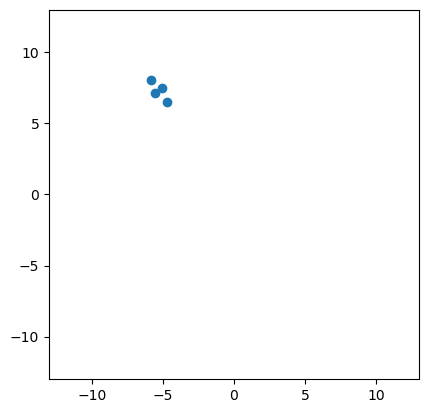

In [79]:
fig, ax = plt.subplots()
ax.scatter(*zip(*points))
ax.set_xlim(-13, 13)
ax.set_ylim(-13, 13)
ax.set_aspect('equal')
plt.show()

In [75]:
points = []
for r in range(len(grid_numbers) + 1):
    for intersection_grids in combinations(grid_numbers, r):
        this_k = ks.copy()
        for grid in intersection_grids:
            this_k[grid] += 1
        
        print(intersection_grids)

        point = np.array([0, 0], dtype=float)
        for k, c, s in zip(this_k, cos_list, sin_list):
            point += k * np.array([c, s])
        points.append(point)
# points

()
(3,)
(4,)
(3, 4)


In [47]:
ks

[-3.0, 0.0, 3.0, 5.0, 5.0]

In [69]:
points

[array([-7.66311896, 10.54737839]),
 array([-6.66311896, 10.54737839]),
 array([-6.85410197, 11.13516364]),
 array([-7.35410197, 11.49843491]),
 array([-5.85410197, 11.13516364]),
 array([-6.35410197, 11.49843491]),
 array([-6.54508497, 12.08622016]),
 array([-5.54508497, 12.08622016])]

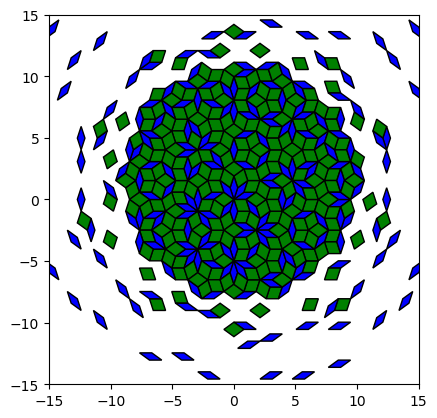

In [77]:
# Area of triangle, would multiply by 2, so don't divide by 2
def determine_area(polygon):
    point_matrix = np.append(np.stack(polygon[0:3]), np.array([[1], [1], [1]]), axis=1)
    return np.round(np.linalg.det(point_matrix), 2)

areas = [determine_area(p) for p in polygons]

colors = ["blue", "green", "yellow", "orange", "red"]
unique_areas = list(set(areas))

fig,ax = plt.subplots()

for polygon, area in zip(polygons, areas):
    c = colors[unique_areas.index(area)]
    p = Polygon(polygon, facecolor = c, edgecolor="k")
    ax.add_patch(p)
    
axis_lim = 15
ax.set_xlim([-axis_lim, axis_lim])
ax.set_ylim([-axis_lim, axis_lim])
ax.set_aspect('equal')
plt.show()

(-2.8, 15.0)
(-2.8, -15.0)
False
False
[(-2.8, 15.0), (-2.8, -15.0)]
(-1.8, 15.0)
(-1.8, -15.0)
False
False
[(-1.8, 15.0), (-1.8, -15.0)]
(-0.8, 15.0)
(-0.8, -15.0)
False
False
[(-0.8, 15.0), (-0.8, -15.0)]
(0.2, 15.0)
(0.2, -15.0)
False
False
[(0.2, 15.0), (0.2, -15.0)]
(1.2, 15.0)
(1.2, -15.0)
False
False
[(1.2, 15.0), (1.2, -15.0)]
(2.2, 15.0)
(2.2, -15.0)
False
False
[(2.2, 15.0), (2.2, -15.0)]
(3.2, 15.0)
(3.2, -15.0)
False
False
[(3.2, 15.0), (3.2, -15.0)]
(-14.359128257079824, 15.000000000000002)
(7.437147583081002, -15.000000000000002)
(15.0, -25.40937333383903)
(-15.0, 15.88208428029618)
[(-14.359128257079824, 15.000000000000002), (7.437147583081002, -15.000000000000002)]
(-13.123060279580034, 15.000000000000002)
(8.673215560580791, -15.000000000000002)
(15.0, -23.70807171713495)
(-15.0, 17.58338589700026)
[(-13.123060279580034, 15.000000000000002), (8.673215560580791, -15.000000000000002)]
(-11.886992302080245, 15.000000000000002)
(9.90928353808058, -15.000000000000002)
(15.0

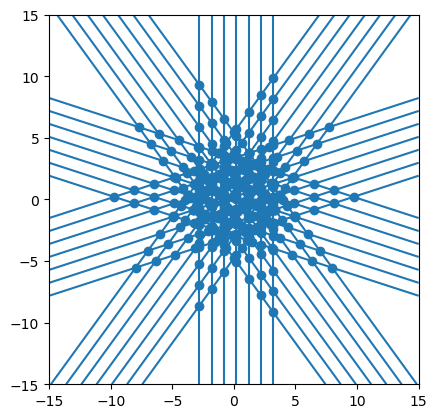

In [76]:
bounds = 15
boundary = [Line(0, 1, bounds, 0), Line(0, 1, -bounds, 0), Line(1, 0, bounds, 0), Line(1, 0, -bounds, 0)]

lines = []

for l in grids:
    points = []
    for b in boundary:
        intersection = l.determine_intersection(b)
        if intersection:
            if ((np.abs(intersection[0]) <= bounds or isclose(np.abs(intersection[0]), bounds)) 
                and (np.abs(intersection[1]) <= bounds or isclose(np.abs(intersection[1]), bounds))):
                points.append(intersection)
        print(intersection)
    print(points)
    lines.append(points)

intersections = defaultdict(set)
for pair in combinations(grids, 2):
    l1 = pair[0]
    l2 = pair[1]
    intersection = l1.determine_intersection(l2)
    if intersection:
        intersections[intersection].update([l1, l2])
intersection_points = list(intersections)

fig, ax = plt.subplots()
ax.add_collection(LineCollection(lines))
ax.scatter(*zip(*intersection_points))
for i, p in enumerate(intersection_points):
    pass#ax.text(x=p[0], y=p[1], s=i)
ax.set_xlim(-bounds, bounds)
ax.set_ylim(-bounds, bounds)
ax.set_aspect('equal')
plt.show()


In [35]:
# 8, .5 breaks everything
# all even numbers break this
# fixed by using isclose
# also, use 8, .25 instead
# write an exception for 8, .5 based on whatever's breaking
# figure out having all offsets be 0?

In [31]:
offsets

array([0, 0, 0, 0, 0])

In [184]:
np.sum(offsets)

1.0

In [8]:
cos_list

[1.0,
 0.8090169943749475,
 0.30901699437494745,
 -0.30901699437494734,
 -0.8090169943749473]

In [9]:
sin_list

[0.0,
 0.5877852522924731,
 0.9510565162951535,
 0.9510565162951536,
 0.5877852522924732]

In [15]:
offsets = np.repeat([1/grid_count, -1/grid_count], grid_count)

In [16]:
offsets

array([ 0.2,  0.2,  0.2,  0.2,  0.2, -0.2, -0.2, -0.2, -0.2, -0.2])

In [21]:
offsets = np.empty((grid_count,),int)
offsets[::2] = 1
offsets[1::2] = -1
offsets

array([ 1, -1,  1, -1,  1])

In [23]:
offsets

array([ 1, -1,  1, -1,  1])